In [2]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm

In [71]:
#scan_name ="YAG_FEL0.2_2605_021"
scan_name ="YAG_400nm_FEL0.3_007"

#DIR = "/sf/alvra/data/p17807/res/scan_data/" + scan_name + "/"
DIR = "/sf/alvra/data/p17808/res/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17808/res/scan_info/"

In [77]:
!ls -la -rt $DIR


!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 1070594
-rw-r--r--.  1 39147 p17808 21437904 May 29 19:30 YAG_400nm_FEL0.3_007_step0000.h5
drwxrwsr-x. 10 39147 p17808     4096 May 29 19:30 ..
-rw-r--r--.  1 39147 p17808 21438640 May 29 19:30 YAG_400nm_FEL0.3_007_step0001.h5
-rw-r--r--.  1 39147 p17808 21438640 May 29 19:30 YAG_400nm_FEL0.3_007_step0002.h5
-rw-r--r--.  1 39147 p17808 21438640 May 29 19:31 YAG_400nm_FEL0.3_007_step0003.h5
-rw-r--r--.  1 39147 p17808 21438640 May 29 19:31 YAG_400nm_FEL0.3_007_step0004.h5
-rw-r--r--.  1 39147 p17808 21438640 May 29 19:31 YAG_400nm_FEL0.3_007_step0005.h5
-rw-r--r--.  1 39147 p17808 21438640 May 29 19:31 YAG_400nm_FEL0.3_007_step0006.h5
-rw-r--r--.  1 39147 p17808 21438640 May 29 19:31 YAG_400nm_FEL0.3_007_step0007.h5
-rw-r--r--.  1 39147 p17808 21438640 May 29 19:32 YAG_400nm_FEL0.3_007_step0008.h5
-rw-r--r--.  1 39147 p17808 21438640 May 29 19:32 YAG_400nm_FEL0.3_007_step0009.h5
-rw-r--r--.  1 39147 p17808 21438640 May 29 19:32 YAG_400nm_FEL0.3_007_step0010.h5
-rw-r--r--.  1 39147

In [80]:
print (channel_BS_pulse_ids)

json_file = DIR_json + scan_name + "_scan_info.json"

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 4
print ("Processing",numFiles,"files")
print (json_file)

Pump_probe = []
err_pump_probe =[]
Delay_mm = []

Izero_FEL_mean = []
err_Izero_FEL_mean = []
Izero_FEL_all = []
Izero_FEL_all_filter = []

PIPS_mean = []
BAM_mean = []
BAM_error = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    exists = os.path.isfile(filename)

    if (exists):
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (Laser_pump, Laser_unpump, Laser_ref_pump, Laser_ref_unpump, Izero_FEL, PIPS, delay, pids_loop) = \
        load_YAG_events(str(data['scan_files'][i][0]))
           
        threshold_FEL = Izero_FEL > 0.1
        condition_FEL = Izero_FEL > np.median(Izero_FEL)-2*(np.std(Izero_FEL))
        condition_laser_pump = ((Laser_pump > 10) & (Laser_ref_pump > 10))
        condition_laser_unpump = ((Laser_unpump > 10) & (Laser_ref_unpump > 10))
        
        Laser_pump = Laser_pump[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        Laser_unpump = Laser_unpump[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        Laser_ref_pump = Laser_ref_pump[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        Laser_ref_unpump = Laser_ref_unpump[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        Izero_FEL_filter = Izero_FEL[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        
        #Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump))
        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
    
        Pump_probe.append(Laser_diff.mean())
        err_pump_probe.append(Laser_diff.std() / np.sqrt(Laser_diff.size))
        
        Izero_FEL_all.append(Izero_FEL)
        Izero_FEL_all_filter.append(Izero_FEL_filter)
        
        Izero_FEL_mean.append(Izero_FEL.mean())
        err_Izero_FEL_mean.append(Izero_FEL.std() / np.sqrt(Izero_FEL.size))
        
        PIPS_mean.append(PIPS.mean())
        #Delay_mm.append(delay.mean())
        Delay_mm.append(delay[0])
        #BAM_mean.append(BAM.mean())
        #BAM_error.append(BAM.std() / np.sqrt(BAM.size))
        
Pump_probe = np.asarray(Pump_probe)
err_pump_probe = np.asarray(err_pump_probe)

Izero_FEL_mean = np.asarray(Izero_FEL_mean)
err_Izero_FEL_mean = np.asarray(err_Izero_FEL_mean)

Delay_mm = np.asarray(Delay_mm)
BAM_mean = np.asarray(BAM_mean)
BAM_error = np.asarray(BAM_error)

SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
Processing 61 files
/sf/alvra/data/p17808/res/scan_info/YAG_400nm_FEL0.3_007_scan_info.json
step 1 of 61 : Processing /sf/alvra/data/p17808/res/scan_data/YAG_400nm_FEL0.3_007/YAG_400nm_FEL0.3_007_step0000.h5
step 2 of 61 : Processing /sf/alvra/data/p17808/res/scan_data/YAG_400nm_FEL0.3_007/YAG_400nm_FEL0.3_007_step0001.h5
step 3 of 61 : Processing /sf/alvra/data/p17808/res/scan_data/YAG_400nm_FEL0.3_007/YAG_400nm_FEL0.3_007_step0002.h5
step 4 of 61 : Processing /sf/alvra/data/p17808/res/scan_data/YAG_400nm_FEL0.3_007/YAG_400nm_FEL0.3_007_step0003.h5
step 5 of 61 : Processing /sf/alvra/data/p17808/res/scan_data/YAG_400nm_FEL0.3_007/YAG_400nm_FEL0.3_007_step0004.h5
step 6 of 61 : Processing /sf/alvra/data/p17808/res/scan_data/YAG_400nm_FEL0.3_007/YAG_400nm_FEL0.3_007_step0005.h5
step 7 of 61 : Processing /sf/alvra/data/p17808/res/scan_data/YAG_400nm_FEL0.3_007/YAG_400nm_FEL0.3_007_step0006.h5
step 8 of 61 : Processing /sf/alvra/data/p17808/res/scan_dat

Total shots= 3900 // filtered=, 3681


<IPython.core.display.Javascript object>


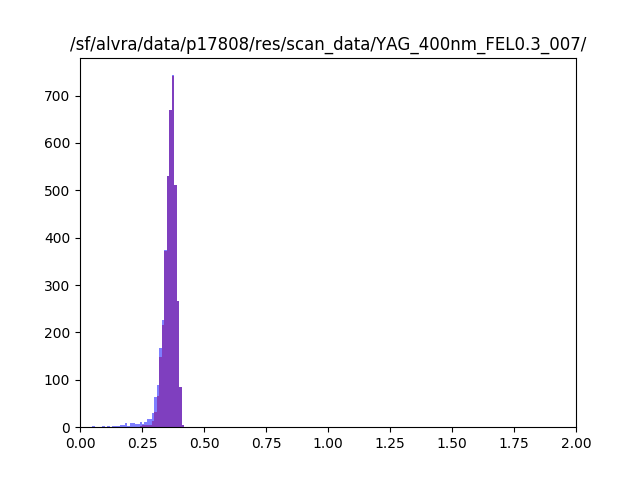

In [61]:
# Check if the condition on the intensity makes sense by looking at the total histogram. 

Izero_total_1D = np.hstack(Izero_FEL_all)
Izero_total_1D_filter = np.hstack(Izero_FEL_all_filter)

print ("Total shots=",Izero_total_1D.size,"// filtered=,",Izero_total_1D_filter.size)
plt.figure()

### ALL STEPS ###
plt.hist(Izero_total_1D_filter, bins = np.arange(0,2,0.01), facecolor='red', alpha=0.5)
plt.hist(Izero_total_1D, bins = np.arange(0,2,0.01), facecolor='blue', alpha=0.5)

### ONLY THE LAST STEP ###
#plt.hist(Izero_FEL, bins = np.arange(0,1.5,0.01), facecolor='blue', alpha=0.5)
#plt.hist(Izero_FEL_filter, bins = np.arange(0,1.5,0.01), facecolor='orange', alpha=0.5)

plt.xlim(0,2)
plt.title(DIR)

plt.show()

<IPython.core.display.Javascript object>


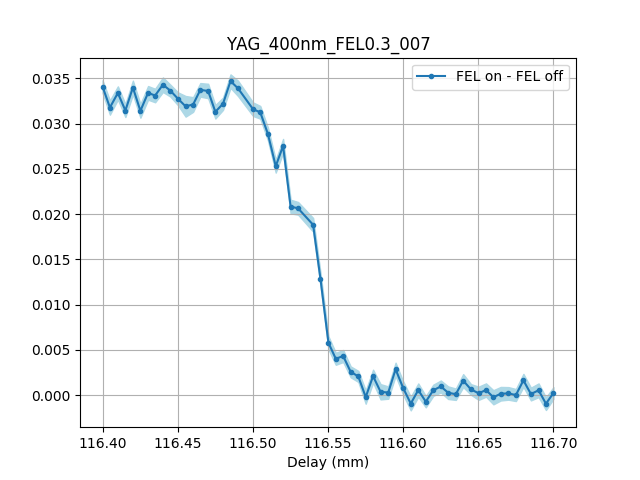

In [85]:
# Plot pump probe signal as a function of delay (stage mm)

#savedir = "/das/work/p17/p17569/Beamline/"
plt.figure()
plt.plot(Delay_mm, Pump_probe, label="FEL on - FEL off",marker='.')

low_err = Pump_probe - err_pump_probe
high_err = Pump_probe + err_pump_probe
plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')

plt.title(scan_name)
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig(savedir + 'LAMcheck_026')

In [82]:
#t0_Time_air = 146.68 # this is from Friday, do not change
t0_Time_air = 116.47624 # this is from Friday, do not change

Delay_ps = 2* (Delay_mm - t0_Time_air)*3.333   # factor of 2 in delay due to the delay stage

In [86]:
#RUN THIS FOR THE FIT !!!

Delay_mm_toFit = Delay_mm.copy()
Delay_ps_toFit = Delay_ps.copy()
Pump_probe_toFit = Pump_probe.copy()

In [87]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(Delay_mm_toFit) | np.isnan(Pump_probe_toFit))

parameters,extras = curve_fit(errfunc_fwhm, Delay_mm_toFit[index], Pump_probe_toFit[index], p0 = [0.01, 0.12, 116.4, 0.1])

print("Position t0 =",np.round(parameters[2],5),"mm")
print("Width =",np.abs(np.round(parameters[3],3))*1000,"um")

Position t0 = 116.53614 mm
Width = 49.0 um


<IPython.core.display.Javascript object>


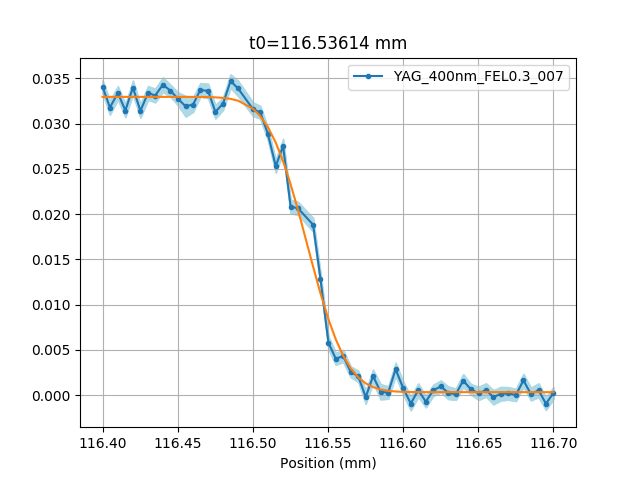

In [88]:
#... and the plot with the fit curve

#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Delay_mm_toFit, Pump_probe_toFit, label=f"{scan_name}",marker='.')
plt.plot(Delay_mm_toFit, errfunc_fwhm(Delay_mm_toFit,*parameters))

low_err = Pump_probe - err_pump_probe
high_err = Pump_probe + err_pump_probe
plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')

plt.fill_between(Delay_mm_toFit, low_err, high_err, color='lightblue')
plt.title('t0=' + str(np.round(parameters[2], 5)) + ' mm' )
plt.grid()
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_YAG_007')

In [24]:
# Now fit IN TIME with error funciton (defined above)
index = ~(np.isnan(Delay_ps_toFit) | np.isnan(Pump_probe_toFit))
parameters,extras = curve_fit(errfunc_fwhm, Delay_ps_toFit[index], Pump_probe_toFit[index], p0 = [0.01, 0.04, 0, 100])

print("Position t0 =",np.round(parameters[2],5)*1000,"fs")
print("Width =",np.abs(np.round(parameters[3],3))*1000,"fs")

Position t0 = -239.76 fs
Width = 843.0 fs


<IPython.core.display.Javascript object>


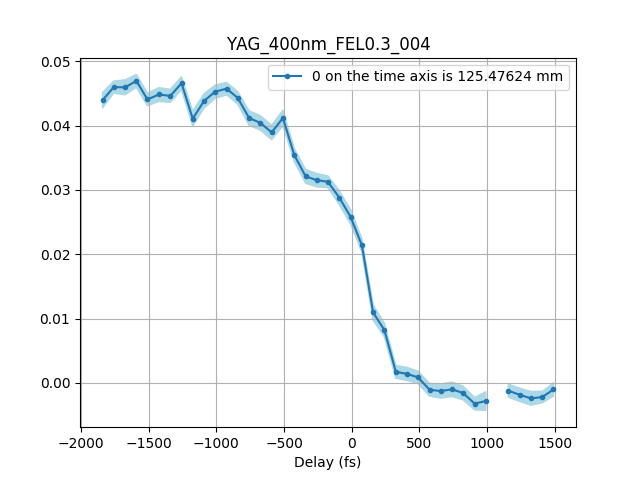

In [36]:
# Plot pump probe signal as a function of time (fs)

#savedir = "/das/work/p17/p17569/Beamline/"


plt.figure()
plt.plot((Delay_ps)*1000, Pump_probe, label="0 on the time axis is %s mm" % t0_Time_air,marker='.')   
plt.plot(label='0 in time is')

low_err = Pump_probe - err_pump_probe
high_err = Pump_probe + err_pump_probe
plt.fill_between(np.squeeze((Delay_ps)*1000), low_err, high_err, color='lightblue')

plt.title(scan_name)
plt.xlabel("Delay (fs)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig('Timescan_7_diode')

<IPython.core.display.Javascript object>


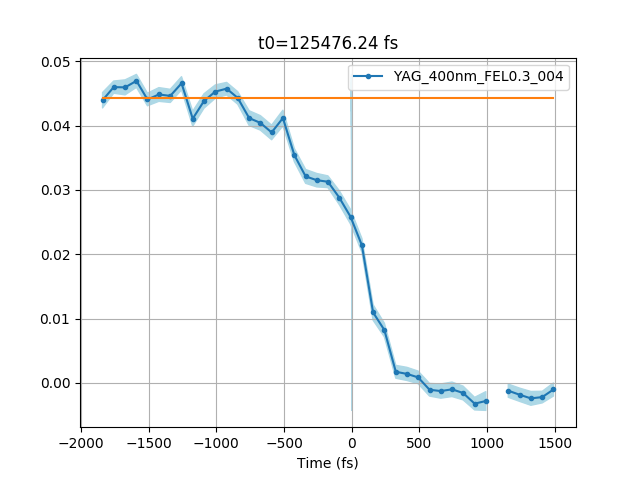

In [13]:
#... and the plot with the fit curve

#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Delay_ps_toFit*1000, Pump_probe_toFit, label=f"{scan_name}",marker='.')
plt.plot(Delay_ps_toFit*1000, errfunc_fwhm(Delay_ps_toFit,*parameters))

low_err = Pump_probe - err_pump_probe
high_err = Pump_probe + err_pump_probe
plt.fill_between(np.squeeze((Delay_ps)*1000), low_err, high_err, color='lightblue')

plt.fill_between(Delay_ps_toFit, low_err, high_err, color='lightblue')
plt.title('t0=' + str(np.round(parameters[2], 5)*1000) + ' fs' )
plt.grid()
plt.xlabel("Time (fs)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_YAG_007')

In [9]:
time_zero = 116.536 - 0.070    #this is in mm from the delay scans (offset of 70 um due to air vs He[100 mbar])

desidered_delay = 10        #choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")

To be at 10 ps, put the laser pump delay stage to 117.9675 mm


In [5]:
offset_space = 100       # this is in um

offset_time = 2*(offset_space * 1e-6)/3e8/1e-15            #factor of 2 because of the delay stage, results in fs
print ("An offset of",offset_space,"um corresponds to an offset of",np.round(offset_time,4),"fs")

An offset of 100 um corresponds to an offset of 666.6667 fs


In [8]:
offset_time = 400000      # this is in fs

offset_space = 3e8 * (offset_time * 1e-15)/2/1e-6          #factor of 2 because of the delay stage, results in um
print ("An offset of",offset_time,"fs corresponds to an offset of",np.round(offset_space,4),"um")

An offset of 400000 fs corresponds to an offset of 60000.0 um


In [4]:
115.536 - 0.070

115.46600000000001